# Title

In [1]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
from trueskill import Rating, rate_1vs1, quality_1vs1
from math import sqrt
from trueskill import BETA
from trueskill.backends import cdf

In [2]:
results = pd.read_csv('./data/results.csv')
results.tail(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
45090,2023-10-17,Zambia,Uganda,3,0,Friendly,Sharjah,United Arab Emirates,True
45091,2023-10-17,Morocco,Liberia,3,0,African Cup of Nations qualification,Agadir,Morocco,False
45092,2023-10-17,England,Italy,3,1,UEFA Euro qualification,London,England,False
45093,2023-10-17,Malta,Ukraine,1,3,UEFA Euro qualification,Ta' Qali,Malta,False
45094,2023-10-17,Serbia,Montenegro,3,1,UEFA Euro qualification,Belgrade,Serbia,False
45095,2023-10-17,Lithuania,Hungary,2,2,UEFA Euro qualification,Kaunas,Lithuania,False
45096,2023-10-17,Finland,Kazakhstan,1,2,UEFA Euro qualification,Helsinki,Finland,False
45097,2023-10-17,Northern Ireland,Slovenia,0,1,UEFA Euro qualification,Belfast,Northern Ireland,False
45098,2023-10-17,San Marino,Denmark,1,2,UEFA Euro qualification,Serravalle,San Marino,False
45099,2023-10-23,United Arab Emirates,Kuwait,1,0,Friendly,Dubai,United Arab Emirates,False


In [3]:
"""
Adding year as a column
"""
results['year'] = results['date'].apply(lambda x:int(x.split('-')[0]))

In [4]:
"""
Adding winner as a column
"""
results.loc[results.home_score > results.away_score, 'winner'] = results.home_team
results.loc[results.home_score < results.away_score, 'winner'] = results.away_team
results.loc[results.home_score == results.away_score, 'winner'] = 'Draw'

In [5]:
home_team = list(results.where(results['year'] > 2000)['home_team'].unique())
away_team = list(results.where(results['year'] > 2000)['away_team'].unique())

In [6]:
def get_ratings(start_year, finish_year):
    all_teams = list(set(home_team + away_team))

    ratings = {team: Rating() for team in all_teams}

    for team in all_teams:

        home_games = results.loc[(results['home_team'] == team) & (results['year'] >= start_year) & (results['year'] <= finish_year)]

        for index in home_games.index:

            if(home_games['winner'][index] == 'Draw'):
                ratings[team], ratings[home_games['away_team'][index]] = rate_1vs1(ratings[team], ratings[home_games['away_team'][index]], drawn=True)

            elif(team == home_games['winner'][index]):
                ratings[team], ratings[home_games['away_team'][index]] = rate_1vs1(ratings[team], ratings[home_games['away_team'][index]])

            else:
                ratings[home_games['away_team'][index]], ratings[team] = rate_1vs1(ratings[home_games['away_team'][index]], ratings[team])
    return ratings

In [45]:
class Simulator:
    def __init__(self, groups: list, ratings: dict):
        self.groups = groups
        self.ratings = ratings


    def win_probability(self, player_rating, opponent_rating):
        delta_mu = player_rating.mu - opponent_rating.mu
        denom = sqrt(2 * (BETA * BETA) + pow(player_rating.sigma, 2) + pow(opponent_rating.sigma, 2))
        return cdf(delta_mu / denom)


    def simulate_game(self, team_a, team_b, group_index):
        draw_prob = quality_1vs1(self.ratings[team_a], self.ratings[team_b])
        win_a_prob = self.win_probability(self.ratings[team_a], self.ratings[team_b])

        draw = False
        if draw_prob > 0.9:
            draw = np.random.choice([True, False])

        if draw:
            self.ratings[team_a], self.ratings[team_b] = rate_1vs1(self.ratings[team_a], self.ratings[team_b], drawn=True)
            self.groups[group_index][team_a] += 1
            self.groups[group_index][team_b] += 1
        else :
            if win_a_prob - np.random.random() >= 0:
                self.ratings[team_a], self.ratings[team_b] = rate_1vs1(self.ratings[team_a], self.ratings[team_b])
                self.groups[group_index][team_a] += 3
            else:
                self.ratings[team_a], self.ratings[team_b] = rate_1vs1(self.ratings[team_a], self.ratings[team_b])
                self.groups[group_index][team_b] += 3


    def simulate_final_game(self, team_a, team_b):
        win_a_prob = self.win_probability(self.ratings[team_a], self.ratings[team_b])

        if win_a_prob - np.random.random() >= 0:
            return team_a
        else:
            return team_b


    def simulate_group_stage(self):
        for group in self.groups:
            teams = [team for team in group.keys()]
            games = list(itertools.combinations(teams, 2))
            for game in games:
                team_a, team_b = game
                self.simulate_game(team_a, team_b, self.groups.index(group))


    def create_8th_final_games(self):
        qualified = [list(group.keys())[:3] for group in self.groups]

        # A = 0
        # B = 1
        # C = 2
        # D = 3
        # E = 4
        # F = 5

        return [
            (qualified[1][0], qualified[0][2]),
            (qualified[0][0], qualified[2][1]),
            (qualified[5][0], qualified[1][2]),
            (qualified[3][1], qualified[4][1]),
            (qualified[4][0], qualified[2][2]),
            (qualified[3][0], qualified[5][1]),
            (qualified[2][0], qualified[3][2]),
            (qualified[0][1], qualified[1][1])
        ]


    def play_final_phase(self, games: list[tuple]):
        next = games

        while len(next) > 2:
            winners = []
            for team_a, team_b in next:
                winner = self.simulate_final_game(team_a, team_b)

                winners.append(winner)

            next = list(zip(winners[::2], winners[1::2]))

            if len(next) == 2:
                final = []
                for team_a, team_b in next:
                    final.append(self.simulate_final_game(team_a, team_b))
                small_final = [team for match in next for team in match if team not in final]
                top4 = [self.simulate_final_game(final[0], final[1])]
                top4.append([second for second in final if second not in top4][0])
                top4.append([self.simulate_final_game(small_final[0], small_final[1])][0])
                top4.append([second for second in small_final if second not in top4][0])
                return top4


    def simulate_euro(self):
        self.simulate_group_stage()

        for i in range(len(self.groups)):
            group = self.groups[i]
            self.groups[i] = dict(sorted(group.items(), key=lambda x: x[1], reverse=True))

        games_8th_final = self.create_8th_final_games()

        return self.play_final_phase(games_8th_final)

In [63]:
groups = [
    {
        'Germany': 0,
        'Scotland': 0,
        'Hungary': 0,
        'Switzerland': 0,
    },
    {
        'Spain': 0,
        'Croatia': 0,
        'Italy': 0,
        'Albania': 0,
    },
    {
        'Slovenia': 0,
        'Denmark': 0,
        'Serbia': 0,
        'England': 0,
    },
    {
        'Netherlands': 0,
        'Austria': 0,
        'France': 0,
        'Poland': 0,
    },
    {
        'Belgium': 0,
        'Slovakia': 0,
        'Romania': 0,
        'Iceland': 0,
    },
    {
        'Turkey': 0,
        'Portugal': 0,
        'Czech Republic': 0,
        'Greece': 0,
    },
]

s = Simulator(groups=groups, ratings=get_ratings(2020, 2024))

In [67]:
nb_iter = 6000
stat_team = {
    'Germany': [0, 0, 0, 0],
    'Scotland': [0, 0, 0, 0],
    'Hungary': [0, 0, 0, 0],
    'Switzerland': [0, 0, 0, 0],
    'Spain': [0, 0, 0, 0],
    'Croatia': [0, 0, 0, 0],
    'Italy': [0, 0, 0, 0],
    'Albania': [0, 0, 0, 0],
    'Slovenia': [0, 0, 0, 0],
    'Denmark': [0, 0, 0, 0],
    'Serbia': [0, 0, 0, 0],
    'England': [0, 0, 0, 0],
    'Netherlands': [0, 0, 0, 0],
    'Austria': [0, 0, 0, 0],
    'France': [0, 0, 0, 0],
    'Poland': [0, 0, 0, 0],
    'Belgium': [0, 0, 0, 0],
    'Slovakia': [0, 0, 0, 0],
    'Romania': [0, 0, 0, 0],
    'Iceland': [0, 0, 0, 0],
    'Turkey': [0, 0, 0, 0],
    'Portugal': [0, 0, 0, 0],
    'Czech Republic': [0, 0, 0, 0],
    'Greece': [0, 0, 0, 0],
}
for i in range(nb_iter):
    podium = s.simulate_euro()
    #print('podium', podium)
    for j in range(4):
        winner = podium[j]
        stat_team[winner][j] += 1 / nb_iter * 100
        #stat_team[winner][j] = stat_team[winner][j].__round__(2)

final_results = dict(sorted(stat_team.items(), key=lambda x: x[1], reverse=True))
print(final_results)

{'England': [28.133333333333017, 25.033333333333193, 24.716666666666544, 22.100000000000026], 'Portugal': [23.44999999999995, 25.299999999999844, 25.31666666666651, 25.916666666666476], 'France': [16.51666666666701, 15.200000000000335, 16.16666666666703, 14.250000000000288], 'Germany': [13.150000000000233, 13.23333333333357, 11.96666666666684, 12.916666666666888], 'Italy': [12.5000000000002, 12.36666666666686, 11.766666666666831, 12.10000000000018], 'Belgium': [6.249999999999983, 8.866666666666687, 10.066666666666746, 12.683333333333543], 'Croatia': [0, 0, 0, 0.016666666666666666], 'Netherlands': [0, 0, 0, 0.016666666666666666], 'Scotland': [0, 0, 0, 0], 'Hungary': [0, 0, 0, 0], 'Switzerland': [0, 0, 0, 0], 'Spain': [0, 0, 0, 0], 'Albania': [0, 0, 0, 0], 'Slovenia': [0, 0, 0, 0], 'Denmark': [0, 0, 0, 0], 'Serbia': [0, 0, 0, 0], 'Austria': [0, 0, 0, 0], 'Poland': [0, 0, 0, 0], 'Slovakia': [0, 0, 0, 0], 'Romania': [0, 0, 0, 0], 'Iceland': [0, 0, 0, 0], 'Turkey': [0, 0, 0, 0], 'Czech Repu

In [68]:
colors = [(0, 1-i, i) for i in np.arange(0,1,1/len(stat_team.keys()))]

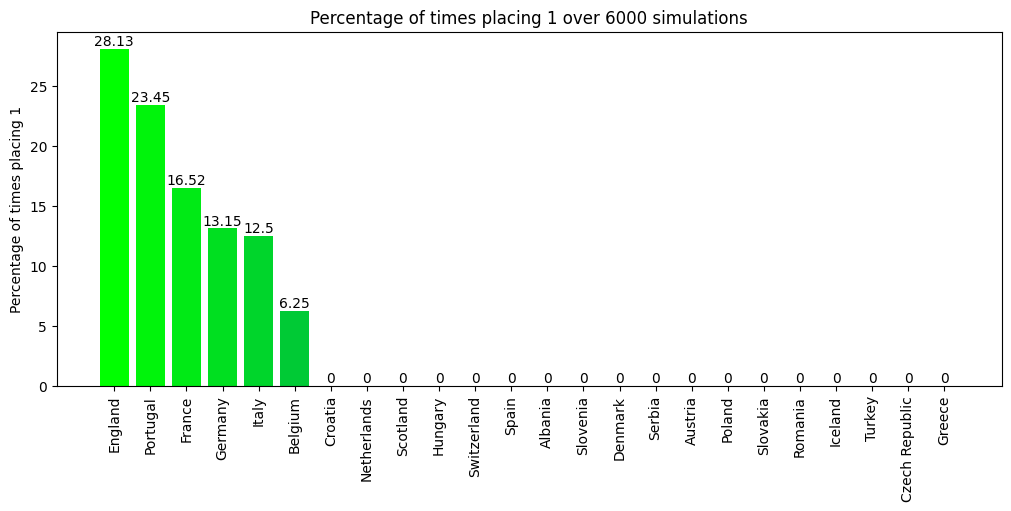

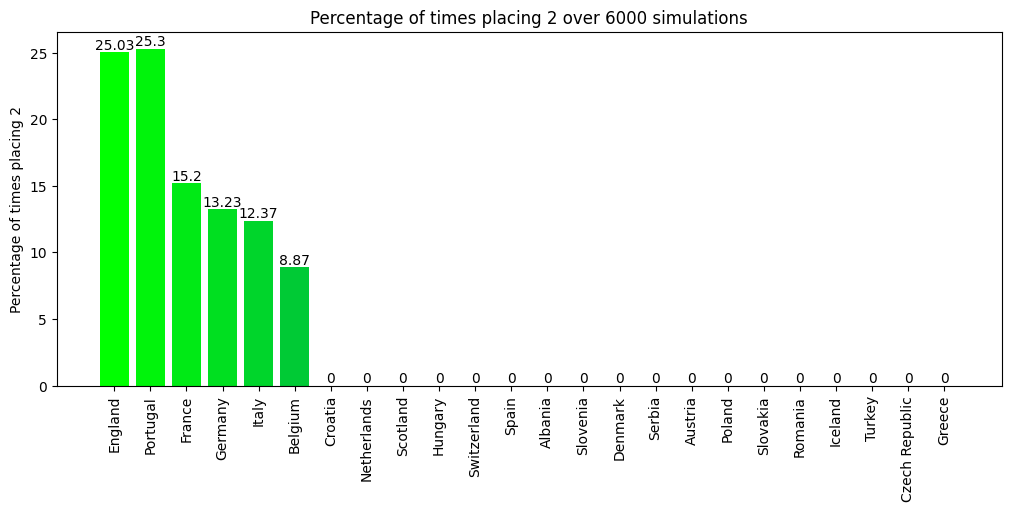

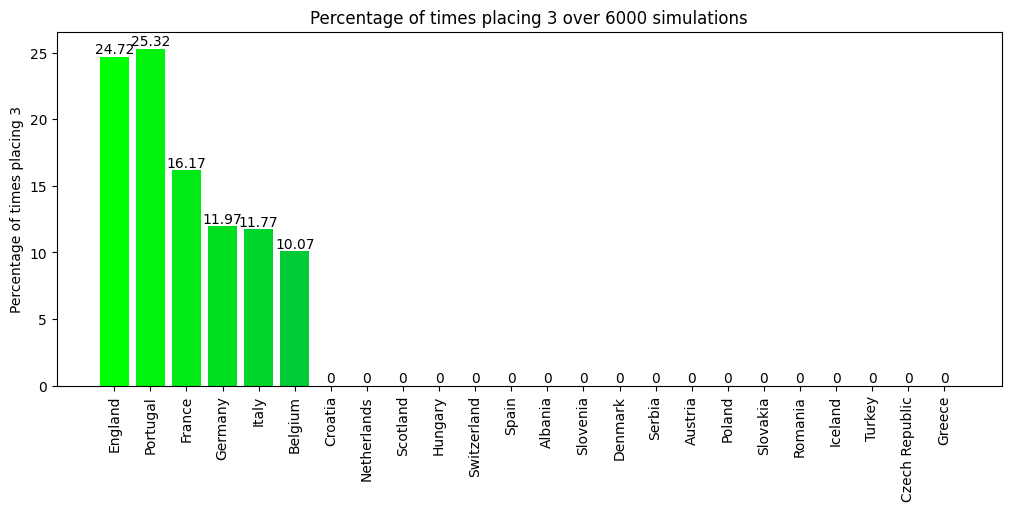

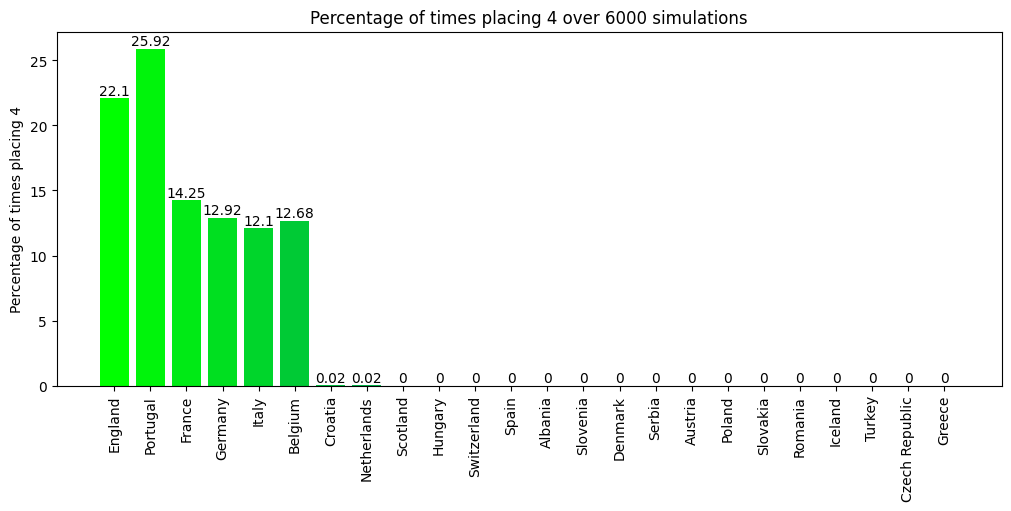

In [71]:
for i in range(4):
    fig, ax = plt.subplots(layout='constrained', figsize=(10, 5))
    rects = ax.bar(final_results.keys(), [round(a[i], 2) for a in final_results.values()], color=colors)
    ax.bar_label(rects, [round(a[i], 2) for a in final_results.values()])
    ax.set_ylabel(f'Percentage of times placing {i+1}')
    ax.set_title(f'Percentage of times placing {i+1} over {nb_iter} simulations')
    ax.tick_params(axis='x', rotation=90)

In [ ]:
test_groups = [
    {
        'Italy': 0,
        'Wales': 0,
        'Switzerland': 0,
        'Turkey': 0,
    },
    {
        'Belgium': 0,
        'Denmark': 0,
        'Finland': 0,
        'Russia': 0,
    },
    {
        'Netherlands': 0,
        'Austria': 0,
        'Ukraine': 0,
        'North Macedonia': 0,
    },
    {
        'England': 0,
        'Croatia': 0,
        'Czech Republic': 0,
        'Scotland': 0,
    },
    {
        'Sweden': 0,
        'Spain': 0,
        'Slovakia': 0,
        'Poland': 0,
    },
    {
        'France': 0,
        'Germany': 0,
        'Portugal': 0,
        'Hungary': 0,
    },
]

test_simulator = Simulator(groups=test_groups, ratings=get_ratings(2016, 2021))

In [ ]:
# Test euro 2021
test_nb_iter = 6000
test_stat_team = {
        'Italy': [0],
        'Wales': [0],
        'Switzerland': [0],
        'Turkey': [0],
        'Belgium': [0],
        'Denmark': [0],
        'Finland': [0],
        'Russia': [0],
        'Netherlands': [0],
        'Austria': [0],
        'Ukraine': [0],
        'North Macedonia': [0],
        'England': [0],
        'Croatia': [0],
        'Czech Republic': [0],
        'Scotland': [0],
        'Sweden': [0],
        'Spain': [0],
        'Slovakia': [0],
        'Poland': [0],
        'France': [0],
        'Germany': [0],
        'Portugal': [0],
        'Hungary': [0],
    }
for i in range(test_nb_iter):
    winner = test_simulator.simulate_euro()[0]
    test_stat_team[winner][0] += 1/test_nb_iter  *100
    test_stat_team[winner][0] = test_stat_team[winner][0].__round__(2)

print(dict(sorted(test_stat_team.items(), key=lambda x: x[1], reverse=True)))